In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys
import os
from tqdm.notebook import tqdm
from itertools import permutations
import torch
import torch.nn.functional as F
from librosa.core import resample
EPS = 1e-8

from modules import *

import pathlib
def create_dir(filename):
    pathlib.Path('/'.join(filename.split('/')[:-1])).mkdir(parents=True, exist_ok=True)
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
old_sr = 8000
new_sr = 8000
dropout = 0.3
half = False
root = '../'
device = 0
devices = [0, 1, 2, 3]

In [2]:
def make_spectrogram(segment):
    segment = segment[50:-50] # make size 200
    S = np.abs(librosa.stft(segment, n_fft = 255, hop_length = 125)) # 32 ms window, 16 ms hop
    return S

def find_max2(tensor):
    array = tensor.cpu().detach().numpy()
    max2 = []
    for row in array:
        max2.append(np.argsort(row)[::-1][:2])
    return np.array(max2)

def compute_corrects(tensor1, tensor2):
    max_1, max_2 = find_max2(tensor1), find_max2(tensor2)
    batch_size = max_1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if Counter(max_1[i])==Counter(max_2[i]):
            batch_corrects+=1
    return batch_corrects



def compute_correct(tensor1, tensor2):
    tensor1, tensor2 = tensor1.cpu().detach().numpy(), tensor2.cpu().detach().numpy()
    batch_size = tensor1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if np.argmax(tensor1[i]) == np.argmax(tensor2[i]):
            batch_corrects += 1
    return batch_corrects

def cross_entropy(input, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * torch.log(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * torch.log(input), dim=1))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


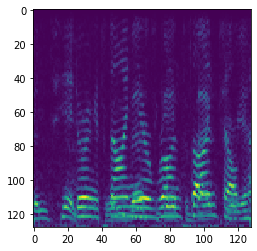

In [3]:
class OverlayDataSet(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.segments = pd.read_csv(root+csv)
        self.speakers = list(set(self.segments['speaker']))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}

    def __len__(self):
        return len(self.segments)
    def __getitem__(self, idx):
        seg1 = self.segments.iloc[idx]
        seg2 = self.segments.iloc[np.random.randint(len(self.segments))]
        while(seg1['speaker']==seg2['speaker']):
            seg2 = self.segments.iloc[np.random.randint(len(self.segments))]

        sig1 = np.load(root+seg1['segfile'])
        sig2 = np.load(root+seg2['segfile'])

        spec1 = np.log(1+make_spectrogram(sig1))[None, ...]
        spec2 = np.log(1+make_spectrogram(sig2))[None, ...]
        source = np.log(1+make_spectrogram(sig1+sig2))[None, ...]
        
        out_vec1 = np.zeros(len(self.speakers)) # maybe try PIT training too
        out_vec2 = np.zeros(len(self.speakers)) # maybe try PIT training too
        out_vec1[self.spkr2idx[seg1['speaker']]] = 1
        out_vec2[self.spkr2idx[seg2['speaker']]] = 1

        return source, np.concatenate((spec1, spec2), axis = 0), out_vec1, out_vec2


#mean, std = compute_mean_std('overlay-train.csv')


trainset = OverlayDataSet('train-segments.csv')
valset = OverlayDataSet('val-segments.csv')
testset = OverlayDataSet('test-segments.csv')
mixture, sources, target1, target2 = trainset[5]
plt.imshow(mixture[0][::-1])
print(target1, target2)

## Maybe try skipping mask directly to last layer

In [25]:
extractor = nn.Sequential(ResidualBlock(1, 128),
                          ResDilationBlock(128, 64),
                          ResDilationBlock(64, 64), # largest dilation is 32
                          ResDilationBlock(64, 64), # largest dilation is 32
                          ResDilationBlock(64, 128),
                          ResDilationBlock(128, 2), # largest dilation is 32
                          nn.ReLU()
                         ).cuda(device)
#checkpoint = torch.load('models/stable/best-joint-extractor-conv.pth')
#checkpoint = torch.load('models/stable/best-joint-extractor-lstm-splice.pth')
checkpoint = torch.load('models/joint-extractor.pth')

extractor.load_state_dict(checkpoint['model_state_dict'])
optimizer1 = torch.optim.Adam(extractor.parameters(), lr = 0.0001)
extractor = torch.nn.DataParallel(extractor, device_ids = devices)

## Splice LSTM discriminator

In [26]:
# len_slice = 20
# shift = 1
# n_hidden = 800
# n_layers = 3
# num_heads = 4
# dropout = 0.3
# class IDnet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size = 128, hidden_size = 200, num_layers = n_layers, dropout = dropout, bidirectional = True)# receptive field 32 frames
#         #self.mha =  nn.MultiheadAttention(n_hidden*2, num_heads = num_heads, dropout = dropout, bias=True) # L * batch * 64
#         self.fc1 = nn.Linear(len_slice*200*2, n_hidden)
#         self.fc2 = nn.Linear(n_hidden, n_hidden)
#         self.fc3 = nn.Linear(n_hidden, 20)
#         self.softmax = nn.Softmax(-1)
#         self.clamp = Lambda(lambda x: x.clamp(min = 1e-8))
#         self.use_all_chunks = True
#         self.act = nn.ReLU()
        
#     def forward(self, X):
#         # [batch_size, 1, F, L]
#         X = X.squeeze(dim = 1).permute(2, 0, 1) # [L, batch_size, F]
#         X = self.chop_chunk(X)
#         out = self.estimate(X)
#         return out
    
#     def predict_chunk(self, chunk):
#         # chunk size : [len_slice, batch_size*n_fr, F]
#         self.lstm.flatten_parameters()
#         X = chunk
#         X, _ = self.lstm(X)
#         #X = self.mha(X)
#         X = X.permute(1, 0, 2).contiguous().view(X.shape[1], -1) # [batch_size*n_fr, n_hidden*len_slice]
#         X = self.act(self.fc1(X))
#         X = self.act(self.fc2(X))
#         X = self.fc3(X)
#         X = self.softmax(X)
#         X = self.clamp(X)
#         return X
    
#     def chop_chunk(self, spec):
#         # [L, batch_size, F]
#         n_frames, batch_size, n_feats = spec.shape
#         N_slices=(n_frames-len_slice)//shift
#         chunks = []
#         for i in range(N_slices):
#             chunks.append(spec[i*shift:i*shift+len_slice]) # list of N_fr elements, each (len_slice*batch_size*F)
#         return chunks
    
#     def estimate(self, chunks):
#         out_vecs = []
#         n_fr = len(chunks)
#         len_slice, batch_size, num_feats = chunks[0].shape
#         if not self.use_all_chunks:
#             indices = np.random.randint(len(chunks), size = 10)
#             chunks = [chunks[index] for index in indices]
#             n_fr = 10
# #            chunks = chunks[::12]
#         chunks = torch.stack(chunks, dim = 2) # [len_slice , batch_size * n_fr , F]
#         chunks = chunks.view(len_slice, -1, num_feats) # [len_slice , batch_size*n_fr, F]
#         out_vecs = self.predict_chunk(chunks) # [batch_size*n_fr, num_spkr]
#         out_tensor = out_vecs.view(batch_size, n_fr, 20) # [batch_size, n_fr, num_spkr]
#         out_tensor = out_tensor.mean(dim = 1) # batch_size*N_spkr
#         return out_tensor 
    
# discriminator = IDnet().cuda(device)
# checkpoint = torch.load('models/stable/best-joint-discriminator-lstm-splice.pth')
# discriminator.load_state_dict(checkpoint['model_state_dict'])
# optimizer2 = torch.optim.Adam(discriminator.parameters(), lr = 0.00001)
# optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
# checkpoint['bestacc']
# discriminator = torch.nn.DataParallel(discriminator, device_ids = devices)

## ResNet Discriminator

In [28]:
class IDnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 7, padding = 3)
        self.res1 = nn.Sequential(ResidualBlock(64, 64),
                                  ResidualBlock(64, 64),
                                  ResidualBlock(64, 64))
        self.mp1 = nn.MaxPool2d(2)
        self.res2 = nn.Sequential(ResidualBlock(64, 128),
                                  ResidualBlock(128, 128),
                                  ResidualBlock(128, 128),
                                  ResidualBlock(128, 128))
        self.mp2 = nn.MaxPool2d(2)
        self.res3 = nn.Sequential(ResidualBlock(128, 256),
                                  ResidualBlock(256, 256),
                                  ResidualBlock(256, 256),
                                  ResidualBlock(256, 256),
                                  ResidualBlock(256, 256),
                                  ResidualBlock(256, 256))
        self.mp3 = nn.MaxPool2d(2)
        self.res4 = nn.Sequential(ResidualBlock(256, 512),
                                  ResidualBlock(512, 512),
                                  ResidualBlock(512, 512))
        self.mp4 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 20)
        self.softmax = nn.Softmax(-1)

    def forward(self, X):
            X = self.conv1(X)
            X = self.mp1(self.res1(X))
            X = self.mp2(self.res2(X))
            X = self.mp3(self.res3(X))
            X = self.mp4(self.res4(X))
            X = X.view(X.shape[0], -1)
            X = self.fc(X)
            X = self.softmax(X)
            X = X.clamp(min = 1e-8)
            return X

discriminator = IDnet().cuda(device)
optimizer2 = torch.optim.Adam(discriminator.parameters(), lr = 0.00001)
#checkpoint = torch.load('models/stable/best-joint-discriminator-conv.pth')
checkpoint = torch.load('models/joint-discriminator.pth')
#bestacc = checkpoint['bestacc']
discriminator = torch.nn.DataParallel(discriminator, device_ids = devices)
discriminator.load_state_dict(checkpoint['model_state_dict'])
#bestacc = 0.0

<All keys matched successfully>

Try local feed forward + MHA

In [29]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)

criterion = cross_entropy

for epoch in range(64):
    extractor.train()
    discriminator.train()
    discriminator.use_all_chunks = False
    running_loss = 0.0
    running_cls_loss = 0.0
    running_accuracy = 0.0
    for batch_idx, (mixture, sources, target1, target2) in enumerate(tqdm(trainloader)):
        optimizer1.zero_grad()
        #optimizer2.zero_grad()

        mixture = mixture.float().cuda(device)
        sources = sources.float().cuda(device)
        target1 = target1.float().cuda(device)
        target2 = target2.float().cuda(device)

        sources_reconstructed = extractor(mixture)
        loss1, min_mse, _, reorder_sources = cal_loss(sources, sources_reconstructed)
        pred1, pred2 = discriminator(reorder_sources[:, 0:1]), discriminator(reorder_sources[:, 1:2])
        pred = torch.stack([pred1, pred2], dim=0)
        pred, _= torch.max(pred, dim=0)
        #loss2 = cross_entropy(pred1, target1) + cross_entropy(pred2, target2)
        loss2 = cross_entropy(pred, target1+target2)
        loss = loss1*5+loss2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(extractor.parameters(), 0.5)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 0.5)
        optimizer1.step()
        optimizer2.step()


        running_loss += loss1.item()
        running_cls_loss += loss2.item()
        running_accuracy += compute_corrects(pred, target1+target2)/batch_size

        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] reconstruction loss: %.3f cls loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_cls_loss/200, running_accuracy / 200))
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer1.state_dict(),
            'loss': running_loss,
            }, 'models/joint-extractor.pth')
            torch.save({
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizer2.state_dict(),
            'acc': running_accuracy
            }, 'models/joint-discriminator.pth')
            running_loss = 0.0
            running_cls_loss = 0.0
            running_accuracy = 0.0

    extractor.eval()
    discriminator.eval()
    discriminator.use_all_chunks = True
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for batch_idx, (mixture, sources, target1, target2) in enumerate(tqdm(valloader)):
            mixture = mixture.float().cuda(device)
            sources = sources.float().cuda(device)
            target1 = target1.float().cuda(device)
            target2 = target2.float().cuda(device)

            sources_reconstructed = extractor(mixture)
            loss1, min_mse, _, reorder_sources = cal_loss(sources, sources_reconstructed)
            pred1, pred2 = discriminator(sources_reconstructed[:, 0:1]), discriminator(sources_reconstructed[:, 1:2])
            pred = torch.stack([pred1, pred2], dim=0)
            pred, _= torch.max(pred, dim=0)


            running_loss += loss1.item()*mixture.shape[0]
            running_accuracy += compute_corrects(pred, target1+target2)

        print('[%d, %5d] reconstruction loss: %.3f accuracy: %.3f' % 
              (epoch + 1, batch_idx + 1, running_loss / len(valset), running_accuracy / len(valset)))

        
        if running_accuracy / len(valset) > bestacc:
            bestacc = running_accuracy / len(valset)
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer1.state_dict(),
            'loss': running_loss,
            }, 'models/best-joint-extractor.pth')
            torch.save({
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizer2.state_dict(),
            'bestacc': running_accuracy / len(valset)
            }, 'models/best-joint-discriminator.pth')
            running_loss = 0.0
            running_cls_loss = 0.0
            running_accuracy = 0.0

KeyboardInterrupt: 

In [ ]:
def compute_half_correct(tensor1, tensor2):
    preds, truth = find_max2(tensor1), tensor2.cpu().detach().numpy()
    batch_size = preds.shape[0]
    half_corrects = 0
    for i in range(batch_size):
        if sum(truth[i][preds[i]]) == 1:
            half_corrects+=1
    return half_corrects

batch_size = 32
for i in range(5):
    testset = OverlayDataSet('test-segments.csv')
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
    extractor.eval()
    discriminator.eval()
    discriminator.use_all_chunks = True
    running_loss = 0.0
    running_accuracy = 0.0
    half_corrects = 0
    with torch.no_grad():
        for batch_idx, (mixture, sources, target1, target2) in enumerate(tqdm(testloader)):
            mixture = mixture.float().cuda(device)
            sources = sources.float().cuda(device)
            target1 = target1.float().cuda(device)
            target2 = target2.float().cuda(device)

            sources_reconstructed = extractor(mixture)
            loss1, min_mse, _, reorder_sources = cal_loss(sources, sources_reconstructed)
            pred1, pred2 = discriminator(sources_reconstructed[:, 0:1]), discriminator(sources_reconstructed[:, 1:2])
            pred = torch.stack([pred1, pred2], dim=0)
            pred, _= torch.max(pred, dim=0)


            running_loss += loss1.item()*mixture.shape[0]
            running_accuracy += compute_corrects(pred, target1+target2)
            half_corrects+= compute_half_correct(pred, target1+target2)
        print('test reconstruction loss: %.4f accuracy: %.4f, half correct: %.4f' % 
              (running_loss / len(testset), running_accuracy / len(testset), half_corrects/ len(testset)))


In [14]:
(0.9159+0.9142+0.9161+0.9173+0.9149)/5

0.91568

In [15]:
(0.9159+0.9142+0.9161+0.9173+0.9149)/5+(0.0819+0.0829+0.0817+0.0798+0.0831)/5

0.99756

In [23]:
(48+52+50+48)/4

49.5

## Measure FLOPS, visualize

In [16]:
extractor.eval()
discriminator.eval()
discriminator.use_all_chunks = True

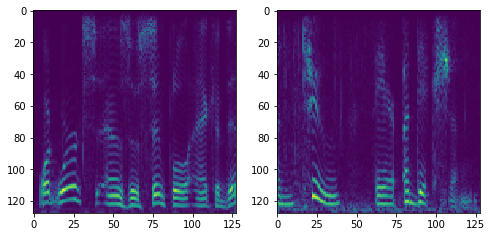

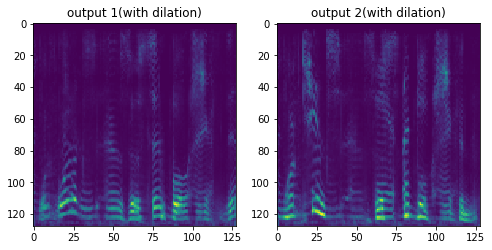

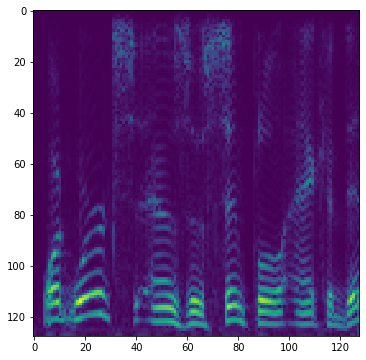

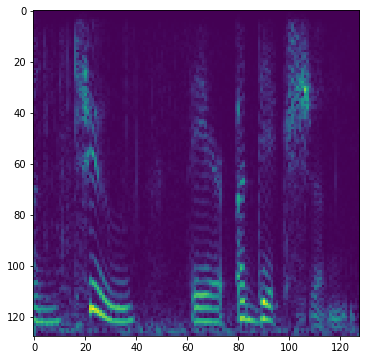

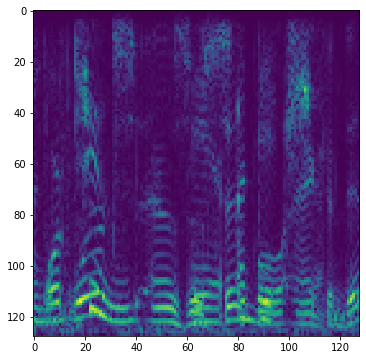

In [17]:
csv = pd.read_csv('../TAS-baseline-2spkr/overlay-test.csv')
row = csv.iloc[17]
sig1, sig2 = row['first_file'], row['second_file']
sig1, sig2 = np.load(root+sig1)/(2**15), np.load(root+sig2)/(2**15)
sig1, sig2 = resample(sig1, 16000, 8000), resample(sig2, 16000, 8000)
spec1, spec2, mixture = np.log(1+make_spectrogram(sig1)), np.log(1+make_spectrogram(sig2)), np.log(1+make_spectrogram(sig1+sig2))
#plt.figure(figsize = (20, 10))
plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.imshow(spec1[::-1])
plt.subplot(122)
plt.imshow(spec2[::-1])

#checkpoint = torch.load('models/pretrained/best-extractor.pth')
#extractor.module.load_state_dict(checkpoint['model_state_dict'])

input = torch.Tensor(spec1+spec2).unsqueeze(0)[None, ...].float().cuda(device)
new_spec1, new_spec2 = extractor(input)[0].detach().cpu().numpy()

plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.imshow(new_spec2[::-1])
plt.title('output 1(with dilation)')
plt.subplot(122)
plt.imshow(new_spec1[::-1])
plt.title('output 2(with dilation)')

plt.figure(figsize = (6, 6))
plt.imshow(spec1[::-1])
plt.figure(figsize = (6, 6))
plt.imshow(spec2[::-1])
plt.figure(figsize = (6, 6))
plt.imshow(mixture[::-1])

In [22]:
from thop import profile
test_extractor = extractor.module
test_extractor.cpu()
input = input.detach().cpu()
macs1, params1 = profile(test_extractor, inputs=(input, ))
print(macs1/10**9, params1/10**6)
test_discriminator = discriminator.module
test_discriminator.cpu()
macs2, params2 = profile(test_discriminator, inputs=(input,))
print(macs2/10**9, params2/10**6)
print((macs1+macs2*2)/10**9, (params1+params2)/10**6)

[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'modules.ResidualBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'modules.ResDilationBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
43.069243392 2.628738
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'modules.ResidualBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Mac